In the previous notebook, we showed how QAOA can approximate the ground state $|\psi_0\rangle$ of a many-body system characterized by a Hamiltonian $H$. We connected this problem to binary optimization in computer science in notebook 4, and used this connection to understand adiabatic quantum computing and variational algorithms.

However, we also talked about the engineering constraints we face in real devices: the evolution in these devices is actually that of an open quantum system, where the quantum processing unit interacts with the environment. In that case, the ground state of $H$ won't be a pure state $|\psi_0\rangle$ but a density matrix $\rho_0$

<img src="../images/open_system.svg" alt="A quantum processor as an open quantum system" style="width: 400px;"/>

The environment is defined by a temperature $T$, and if we let the system equilibrate, the QPU will become thermalized at temperature $T$. As we saw in the notebook on evolution in open and closed systems, the energy of the states will follow a Boltzmann distribution: $\rho_0=\frac{1}{Z} e^{-H/T}$ where $Z=tr (e^{-H/T})$ is a normalization factor (called the *partition function*), ensuring that $tr(\rho_0)=1$. The inverse temperature $1/T$ is often denoted by $\beta$, so the state can also be written as $\rho_0=\frac{1}{Z} e^{-\beta H}$. If $H$ has a discrete basis of orthonormal eigenstates $\{|n\rangle\}$ with eigenvalues $\{E_n\}$, we can write $H=\sum_n E_n |n\rangle \langle n|$ and $\rho_0=\frac{1}{Z} \sum_n e^{-E_n/T} |n\rangle \langle n|$ (since exponentiating a diagonal operator consists in exponentiating the elements of the diagonal). Hence, the thermal density matrix is a mixed state where each eigenstate of $H$ with energy $E$ has a classical probability $P(E)=\frac{1}{Z} e^{-E/T}$, a Boltzmann distribution. We can see that the minimum energy eigenstate will have the highest probability. When $T \rightarrow 0$, the minimum energy eigenstate will have a probability close to $1$. When $T \rightarrow \infty$, all the eigenstates tend to have equal probability.

The question that arises now is: how to approximate this thermalized state $\rho_0$ of the Hamiltonian $H$ using a quantum circuit? For pure ground states, there were two methods: quantum annealing and QAOA. We will see here that those two methods can be adjusted to also prepare thermalized density matrices.

We will see later that we can use this preparation to train certain machine learning models.

# Quantum annealing

Let us start by importing a handful of packages:

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import dimod
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

We are interested in the thermal state of the classical Ising model. We create a random model over ten spins and we will sample a hundred states.

In [2]:
n_spins = 10
n_samples = 1000
h = {v: np.random.uniform(-2, 2) for v in range(n_spins)}
J = {}
for u, v in itertools.combinations(h, 2):
    if np.random.random() < .05:
        J[(u, v)] = np.random.uniform(-1, 1)
model = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.SPIN)
sampler = dimod.SimulatedAnnealingSampler()

Let's sample the energies at different temperatures. The `dimod` implementation of simulated annealing allows us to set an initial and final temperature for the annealing. If we set it to the same value, we mimic the effect of a finite temperature and we will have a wider range of configurations and energy levels in the samples. The next cell can take a while to execute.

In [3]:
temperature_0 = 1
response = sampler.sample(model, beta_range=[1/temperature_0, 1/temperature_0], num_reads=n_samples)
energies_0 = [solution.energy for solution in response.data()]
temperature_1 = 10
response = sampler.sample(model, beta_range=[1/temperature_1, 1/temperature_1], num_reads=n_samples)
energies_1 = [solution.energy for solution in response.data()]
temperature_2 = 100
response = sampler.sample(model, beta_range=[1/temperature_2, 1/temperature_2], num_reads=n_samples)
energies_2 = [solution.energy for solution in response.data()]

We define a function to plot the resulting probability distribution.

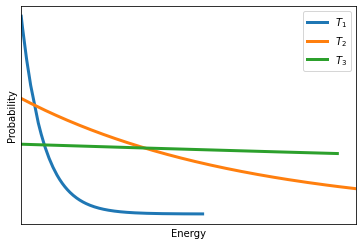

In [4]:
def plot_probabilities(energy_samples, temperatures):
    fig, ax = plt.subplots()
    for i, (energies, T) in enumerate(zip(energy_samples, temperatures)):
        probabilities = np.exp(-np.array(sorted(energies))/T)
        Z = probabilities.sum()
        probabilities /= Z
        ax.plot(energies, probabilities, linewidth=3, label = "$T_" + str(i+1)+"$")
    minimum_energy = min([min(energies) for energies in energy_samples])
    maximum_energy = max([max(energies) for energies in energy_samples])
    ax.set_xlim(minimum_energy, maximum_energy)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Energy')
    ax.set_ylabel('Probability')
    ax.legend()
    plt.show()

plot_probabilities([energies_0, energies_1, energies_2], 
                   [temperature_0, temperature_1, temperature_2])

Just as we saw in the introduction, the distribution flattens out at a high temperature ($T_3$). On the other hand, the energy is peaked for a low temperature, and we do not even have samples for high-energy states.

# Quantum Approximate Thermalization

There are many results for preparing a thermal state on a gate-model quantum computer, but most of them need a large-scale device. More recently, a protocol for approximating thermalization was developed using shallow circuits [[1](#1)]. The idea is that if we knew that the thermal state was a pure state $\psi$ (which means $\rho=|\psi \rangle \langle \psi |$), we could apply QAOA to get to the thermal state of a target Hamiltonian. Since QAOA approximates the adiabatic pathway, it should be a conservative change, so at the end of it, we would be close to the thermal state of the target Hamiltonian.

To find the thermal state of the simple system, the trick is to purify $\rho$ on a larger Hilbert space. If we call $\mathcal{H_1}$ our current Hilbert space, purifying a density matrix $\rho$ consists of finding a second Hilbert space $\mathcal{H_2}$ such that there exists $| \psi \rangle \in \mathcal{H_1} \otimes \mathcal{H_2}$ such that $\rho = \textrm{Tr}_{\mathcal{H_2}} \left( |\psi \rangle \langle \psi | \right)$, where $\textrm{Tr}_{\mathcal{H_2}}$ is the partial trace taken over the second Hilbert space -- in essence, we are marginalizing the probability distribution. This resembles the idea of what we shown in the notebook on measurements and mixed states: if we trace out a subsystem of the maximally entangled state $|\phi^+\rangle$, we get the maximally mixed state. The maximally mixed state is essentially a thermal state at infinite temperature.

It can be shown that $| \psi \rangle =1/\sqrt{2 \cosh \frac{1}{2T}} \sum_{z \in {-1,1}} e^{- \frac{z}{2T}} |z \rangle_{\mathcal{H_1}} \otimes | z \rangle_{\mathcal{H_2}}$ purifies $\rho=\frac{1}{Z}e^{- H_m/T}$ [[1](#1)], where $H_m$ is the mixing Hamiltonian in QAOA. This state can be built with a circuit composed uniquely of RX gates and CNOT gates

In [5]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from functools import reduce, partial
from scipy.optimize import minimize

from qiskit import Aer, QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit import execute
from qiskit.quantum_info import Pauli

#from qiskit.aqua import get_aer_backend,
from qiskit.aqua import QuantumInstance
from qiskit.aqua.operator import Operator
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.algorithms import QAOA
from qiskit.aqua.components.initial_states.custom import Custom

ImportError: cannot import name 'get_aer_backend' from 'qiskit.aqua' (/usr/local/lib/python3.8/site-packages/qiskit/aqua/__init__.py)

## High temperature

We create an example system of two qubits that needs two extra qubits for purification. In this first example, we set $T=1000$.

In [ ]:
n_qubits = 2
n_system = n_qubits * 2
T = 1000

We define a simple Ising model with a weight matrix and set $p=1$ in QAOA.

In [ ]:
weights = np.array([[0,1],[0,0]])
p = 2

Based on these parameters, we define the Ising Hamiltonian $H=\sum W_{ij} \sigma_i\sigma_j$ (for the weight matrix defined above, $H=\sigma_1 \sigma_2$, whose minimum is reached when $\sigma_1 \neq \sigma_2$)

In [ ]:
def pauli_z(qubit, coeff):
    eye = np.eye((n_system))
    return Operator([[coeff, Pauli(eye[qubit], np.zeros(n_system))]])

def product_pauli_z(q1, q2, coeff):
    eye = np.eye((n_system))
    return Operator([[coeff, Pauli(eye[q1], np.zeros(n_system)) * Pauli(eye[q2], np.zeros(n_system))]])

def ising_hamiltonian(weights):
    H = reduce(lambda x,y:x+y,
            [product_pauli_z(i,j, -weights[i,j])
             for (i,j) in itertools.product(range(n_qubits), range(n_qubits))])
    H.to_matrix()
    return H

In [ ]:
Hc = ising_hamiltonian(weights)

We prepare the intial state $|\psi_0 \rangle = 1/\sqrt{2 cosh(\frac{1}{2T})} \sum_{z \in {1, -1}} e^{- z/T} | z \rangle_S \otimes | z \rangle_E$, with $E$ a temporary space used for purification purpose. It can be shown that tracing out this state over $E$ reproduces the state $\rho \propto e^{-H_m/T} $. We initialize the circuit first:

In [ ]:
qr = QuantumRegister(n_system)
cr = ClassicalRegister(n_qubits)
backend = Aer.get_backend('qasm_simulator')

And we prepare the state:

In [ ]:
def prepare_init_state(T):
    init_circuit = QuantumCircuit(qr)
    α = 2 * np.arctan(np.exp(- 1/T))
    for i in range(n_qubits):
        init_circuit.rx(α, qr[n_qubits+i])
        init_circuit.cx(qr[n_qubits+i], qr[i])
    init_state = Custom(n_system, circuit=init_circuit)
    return init_state

We will now use the QAOA implementation of Qiskit Aqua, with the above initial circuit appended to the regular variational circuit.

In [ ]:
def get_thermal_state(T):
    print("Begin QAOA...")
    
    optimizer = COBYLA()
    initial_state = prepare_init_state(T)
    qaoa = QAOA(Hc, optimizer, p, initial_state)
    backend = get_aer_backend('statevector_simulator')
    quantum_instance = QuantumInstance(backend)
    result = qaoa.run(quantum_instance)
    print("Results of QAOA", result)
    
    return qaoa.get_optimal_cost(), qaoa.get_optimal_circuit()

We run the protocol to get the thermal state:

In [ ]:
cost, thermal_state = get_thermal_state(T)
print("Result of QAOA", cost)

Finally, we reformat the final results, measure out the result, and plot the energy distribution:

In [ ]:
def get_energy(spin_configuration):
    x = spin_configuration.reshape(-1, 1)
    return np.sum([[-weights[i,j] * x[i] * x[j] for j in range(n_qubits)] for i in range(n_qubits)])

def get_energy_distribution(thermal_state):
    thermal_state.add_register(cr)
    for i in range(n_qubits):
        thermal_state.measure(qr[i], cr[i])
        job = execute(thermal_state, backend, shots=1000)
    results = job.result().get_counts(thermal_state)
    
    list_spin_configs = np.array(np.concatenate([[list(spin_config)] * results[spin_config] for spin_config in results]), dtype="int")
    list_spin_configs[list_spin_configs == 0] = -1
    list_energy = np.array([get_energy(spin_config) for spin_config in list_spin_configs])
    return list_energy

In [ ]:
list_energy = get_energy_distribution(thermal_state)
hist = plt.hist(list_energy, density=True)

The two eigenvalues, i.e. possible energies, of our Hamiltonian $H=\sigma_1 \sigma_2$ are $E=-1$ and $E=1$. At infinite temperature ($\beta=0$), they should be assigned an equal probability, which is the case in the histogram above. Let's repeat the experiment at a lower temperature.

## Low temperature

We set $T=0.5$. With this, we should get the lowest energy with a high probability.

In [ ]:
T = 0.5

In [ ]:
cost, thermal_state = get_thermal_state(T)

list_energy = get_energy_distribution(thermal_state)
hist = plt.hist(list_energy, density=True)

The minimum energy eigenstate should now have a much higher probability. Try to repeat the experiment with different $\beta$ to see the effect of the temperature on the prepared thermal state.

# References

[1] Verdon, G., Broughton, M., Biamonte, J. (2017) [A quantum algorithm to train neural networks using low-depth circuits](https://arxiv.org/abs/1712.05304). *arXiv:1712.05304*. <a id='1'></a>